# Recommender System for Travel App

### Let's import some useful libraries

In [1]:
import torch
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pickle as pkl
import torch.autograd as autograd
import torch.nn as nn
import os
import math
from collections import Counter
import random
import gensim
import nltk
import random
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import enchant
import matplotlib.pyplot as plt
from nltk import WordNetLemmatizer, word_tokenize, bigrams, ngrams, RegexpTokenizer
lemmatize = WordNetLemmatizer()
%matplotlib inline

### Here is the code for the recommender system.  This consists of a deep auto-encoder with a 'fit' and 'predict' method like sklearn.

In [88]:
class recsys(nn.Module):
    
    
    def __init__(self,ratings=None,users=100,sites=1000,latent_features=10,\
                 dropout=.1,max_iter=10,epochs=4,temperature=1,lr=.01,batch_size=500,\
                 losses=None):
        
        super(recsys,self).__init__()
        
        
        self.users=users
        self.sites=sites
        self.dropout=nn.Dropout(p=dropout)
        self.max_iter=max_iter
        self.lr=lr
        self.batch_size=batch_size
        self.temperature=temperature
        self.ratings=ratings
        self.losses=None
        self.epochs=epochs
        self.linear1=nn.Linear(sites,latent_features)
        self.linear2=nn.Linear(latent_features,latent_features)
        self.linear3=nn.Linear(latent_features,sites)
    
    
    # The input x should have shape (number_of_users,sites)
    # Ratings needs to be a torch tensor of the same shape as x.
    
    
#     def get_mask(self,ratings=None):

#         try: 
#             if ratings==None:
#                 pass
#         except:
#             self.ratings=ratings
            
#         mask=[]
#         for i in range(len(self.ratings)):
#             mask.append([0 if math.isnan(self.ratings[i,j]) else 1 for j in range(len(self.ratings[0]))])
#         return torch.tensor(mask)
       
    
    
    def imputer(self,x=None):
        #Need to make a function which takes in a ratings array and returns
        #an initial best guess.  For now I'll just mask the unkown variables
        #print(type(self.ratings))
        
        try: 
            if x==None:
                ratings=self.ratings
        except:
            ratings=x

                
        ratings[np.isnan(ratings)] = 0
        return torch.tensor(ratings).float()
    

    
    def forward(self,x):
        x=self.imputer(x)
        x=self.linear1(x.float())
        x=torch.tanh(x)
        x=self.linear2(x.float())
        x=self.dropout(x.float())
        x=torch.tanh(x)
        x=self.linear3(x.float())
        return x
    
    
    def custom_loss(self,x,y):
        ct=0
        for i in range(len(x)):
            if (torch.norm(x[i])==0) or (torch.norm(y[i])==0):
                pass
            else:
                ct+=1-(x[i]@y[i])/(torch.norm(x[i])*torch.norm(y[i]))
        return ct/len(x)


    
    def predict(self,x):
        x=self.imputer(x)
        return self.forward(x)
    
    def fit(self,ratings=None):
        
        try: 
            if ratings==None:
                ratings=self.ratings
    
        except:
            pass

        ratings_clean=self.imputer(ratings)
       
        

        loss_function=nn.MSELoss()
    
        


        f= open('data/losses','w+')

        losses=[]

        for i in range(1,self.epochs+1):
            
            optimizer = optim.Adam(self.parameters(),lr=self.lr/i)
            
            print(f'Epoch {i}')
            
            sample_indices=np.random.choice(range(len(ratings_clean)),self.batch_size,replace=False)
            sample=ratings_clean[sample_indices]
            #print(sample_indices)
            
            for _ in range(self.max_iter):
                optimizer.zero_grad()
                out = self.forward(sample)
                #out = self.forward(ratings_clean)
                #loss = loss_function(out,ratings_clean) #This one works!
                loss = self.custom_loss(out,sample)  #This one works
                #loss = self.custom_loss(out,ratings_clean)
                losses.append(float(loss.detach().numpy()))
                f.write(str(loss.detach().numpy())+',')
                loss.backward(retain_graph=True)
                
                optimizer.step()
            self.losses=losses
        f.close()

### Now we instantiate an instance of the class recsys.  We also pick some hyperparameters. 

In [105]:
test=recsys(users=100,sites=1000,latent_features=20,dropout=0,epochs=10,max_iter=100,lr=.01,batch_size=50)


### We need some data to run this one.  Let's make some data up.

In [101]:
data=[]
users=100
sites=1000
ranked=30
for j in range(users):
    ra=np.random.choice(range(users),ranked)
    data.append(np.array([10*random.random() if (i in ra) else float('NaN') for i in range(sites)]))
data=np.array(data)

### Calling the fit method on this 'data'

In [106]:
test.fit(data)

Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10


### We now have a fit model.  Let's check the loss function.  The losses are stored in the recsys class, so we can just call 'test.losses' to get a list of losses for each iteration.

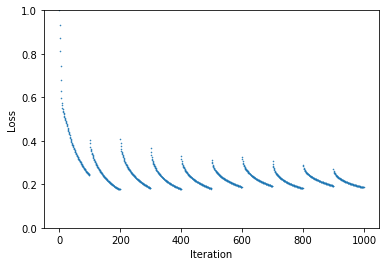

In [107]:
plt.scatter(list(range(len(test.losses))),test.losses,s=.3)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.ylim(0,1)
plt.show()

In [108]:
test.losses[-1]

0.1856667846441269

Here we see that the loss goes up near the beginning of each batch, but the overall trend is towards lower loss.

### Now we can make some predictions for a new user....  Since I'm lazy, I'll just make a prediction for one of the previously seen users.  The call looks like this:

In [7]:
predictions=test.predict(data[2])

# Making Predictions w/ Real Data

Now we need to run this with some real data.  Below we have some functions to clean the data.  The data is coming from https://www.tripadvisor.com/ and https://trip.sftravel.com/.

In [68]:
#Results is a list of user rankings of various attractions in SF.  It is structured as a list of json
# like files of the form [{user1:{attraction1:rating1,attraction2:rating2,attraction3:rating3}, user2:...}]

results=[]
for k in range(100,10000,100):
    with open(f'data/file_{k}.pkl','rb') as f:
        likes=pkl.load(f)
        results.append(likes)
    
# Now we need to combine all the results above into one big dictionary.    
              
res=results[0]
for i in range(1,len(results)):
    res={**res,**results[i]}
    
# We need a dictionary to map trip adviser names to sf_travel site names:  

with open('data/ta_to_sf.pkl','rb') as f:
    ta_to_sf=pkl.load(f)
    
# Finally, we import a dictionary which maps trip-adviser sites to features.
    
with open('data/ta_feature_dct.pkl','rb') as f:
    ta_feature_dct=pkl.load(f)

In [80]:

# make_matrix takes in a list of rankings of attractions as well as a dictionary (site to labels) and spits out 
# 1) an array of user preferences, 2) a list of users and 3) a list of attractions.  

def make_matrix(users,ta_to_sf):
    user_list=list(users.keys())
    places=[]
    for user_key in users.keys():
        for place in users[user_key].keys():
            place_minus_sf=place[15:]
            if place_minus_sf in list(ta_to_sf.keys()):
                places.append(place)
    places=list(set(places))


    matrix=[]
    for u in user_list:
        user_likes=[]
        for p in places:
            if p in users[u].keys():
                user_likes.append(users[u][p])
            else:
                user_likes.append(float('NaN'))
        matrix.append(user_likes)

    return np.array(matrix), user_list, places


# get_data takes in the results 'res' above and spits out a 'clean' matrix of user preferences
# as well as a list of users and places.  This is basically a cleaned version of 'make_matrix'

def get_data(res,ta_to_sf):
    
    matrix, user_list, places = make_matrix(res,ta_to_sf)
    
    good_list=[]
    for i in range(len(matrix)):
        if sum(np.nan_to_num(matrix[i],0))!=0:
            good_list.append(i)
            
    users_clean=np.array(user_list)[good_list]
    matrix_clean=matrix[good_list]
    return matrix_clean, users_clean, places

# make profiles creates a user profile based on past data and the labels for each site that were scraped from 
# sf_trip

def make_profiles(matrix,ta_features_dct):
    profiles={}
    for u in range(len(matrix)):
        st=''
        for i in range(len(matrix[0])):
            st+=int(matrix[u][i])*(ta_feature_dct[places[i][15:]]+' ').replace(' & ','+').replace('Must See','Must-See')
        res1=Counter(flatten([style_mapper[x.strip(',')] for x in st.split()]))
        keys=res1.keys()
        res1p={k:10*res1[k]/sum([res1[k] for k in keys]) for k in keys}
        profiles[u]=res1p
    return profiles

#Now we convert the profiles to numpy.

def convert_profile_to_np(profiles,attributes=['Nature','History','Culture','Life']):
    np_profiles=[]
    for u in range(len(matrix)):
        user_profile=[]
        for a in attributes:
            if a in profiles[u].keys():
                user_profile.append(profiles[u][a])
            else:
                user_profile.append(0)
        np_profiles.append(user_profile)
    return np.array(np_profiles)

#Flatten is just a helper function for 'make_profiles'

def flatten(testlist):
    acc=[]
    for x in testlist:
        if type(x)==str:
            acc.append(x)
        elif type(x)==list:
            acc+=x
    return acc

# This is just a wrapper for creating the recsys class.  The wrapper allows us to automatically initialize
# the number of users and attractions

def create_recsys(matrix,dropout=.1,latent_features=4,max_iter=100,lr=.001,epochs=5,temperature=1,batch_size=500):
    return recsys(matrix,matrix.shape[0],matrix.shape[1],latent_features,dropout,max_iter,epochs,temperature,lr,\
                 batch_size=batch_size)


style_mapper={'Adventure':'Nature', 'Art':'Culture','Cuisine':'Life','Culture':'Culture',\
              'Fun+Entertainment':['Life','History'],'History':'History','Landmark':'History','Museum':'Culture',\
              'Must-See':'History','Nature':'Nature','Nightlife':'Life','Shopping':'Life','Sports':'Life',\
              'Tour':'Life','R+R':'Life'}

## Building and Training Model

### Now that we have the code above it is simple to train a model.  

In [76]:
matrix, users, places = get_data(res,ta_to_sf)

In [77]:
profiles=make_profiles(matrix,ta_feature_dct)

np_profiles=convert_profile_to_np(profiles)

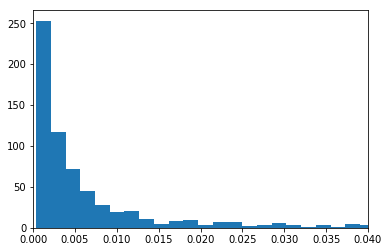

In [189]:
plt.hist(testsum,bins=1000)
plt.xlim(0,.04)
plt.show()

In the next line we make a new array which combines the generated user profiles with their historical data.  

In [78]:
new_matrix=np.concatenate((np_profiles,matrix),axis=1)

Now we want to train a model on our data.  Since the training is going to take a long time let's just look at a small sample to see if things are working.  I'll pick 500 users randomly just to get started. I'll also initialized a recsys using the create_recsys function above.

In [111]:
#sample=np.random.choice(range(len(new_matrix)),50,replace=False)
test_real=create_recsys(new_matrix,max_iter=100,lr=.01,epochs=10,batch_size=500,latent_features=10)

In [198]:
#Let's compute the average and std rating for each site.

full_predictions=test_real.predict(new_matrix)
full_predictions2=full_predictions[:,4:].detach().numpy()
averages=[np.mean(full_predictions2[:,i]) for i in range(len(places))]
stds=[np.std(full_predictions2[:,i]) for i in range(len(places))]

In [112]:
test_real.fit()

Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10


Now we have a fit model.  Let's suppose a new user comes along with no previous history.  We will ask him to fill out fill out a questionaire describing his/her preference for ['Nature','History','Culture','Life'], in that order.

In [271]:
preferences=[1,3,3000000,30]

# This user really likes nature, sort of likes culture, but is ambivalent about history and 'life'.
# Note that the internally the scores are normalized such that the sum is 10, hence the extra factors below. 

new_user_preferences=(10/sum(preferences))*np.array(preferences)

#Since we know nothing about the new user we just initialize their site rankings to zero. 

initialization=np.zeros(len(matrix[0]))

#Finally, we combine the preferences with the initialization to represent the new user as a row.

new_user=np.concatenate((new_user_preferences,initialization),axis=0)

In [272]:
#Let's figure out what the user likes!
predictions_raw=test_real.predict(new_user)

In [273]:
# These are raw predictions.  We want to filter out the 'background effect'.  To do this we subtract off the average preferences.

predictions_shifted=predictions_raw[4:].detach().numpy()-np.array(averages)
predictions=sorted(list(enumerate([predictions_shifted[i]/stds[i] for i in range(len(predictions_shifted))])),\
                   key=lambda x: x[1],reverse=True)

In [274]:
#Let's figure out what the user likes!
#predictions=sorted(list(enumerate(test_real.predict(new_user))),key=lambda x: x[1],reverse=True)
sites=[[places[p[0]][15:],float(p[1])] for p in predictions[:10]]
sites

[['Exploratorium', 3.054027557373047],
 ['El Farolito', 2.9732000827789307],
 ['Sears Fine Foods', 2.934149742126465],
 ['Redwood Room', 2.9312620162963867],
 ['MarketBar', 2.9106202125549316],
 ['Asian Art Museum', 2.898400068283081],
 ['Slanted Door', 2.7908637523651123],
 ['Waterbar', 2.7648088932037354],
 ['State Bird Provisions', 2.751325845718384],
 ['Prospect', 2.7462496757507324]]

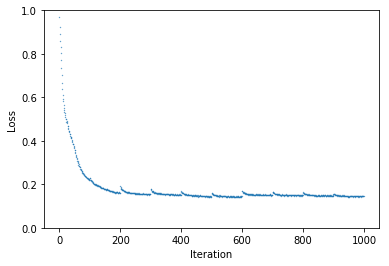

In [116]:
plt.scatter(list(range(len(test_real.losses))),test_real.losses,s=.1)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.ylim(0,1)
plt.show()

## Notes:

The results are not very representative of the user profile.  One might hope that if we set the user profile to 'nature=10, else=0', we would only get outdoors activities.  The problems is that everything is filtered through a neuro network which is influenced by what the 'nature-lovers' and others actually did in the past.....  These past actions are not necessarily in alignment with the ratings....  

Let's imagine a simpler world where any user who likes nature ONLY visits natural attractions... I.e., there is a strong correlation between the labels and what one actually does.  In this world, we should be able to pick out purely 'natural' activies....

Need to transform rankings to something like "10(site_score_for_user - avg_site_score)"

Also, are we really masking unseen data??? 